### NIR Data

In [1]:
import pyodbc
import pandas as pd
from hvacmnircreds import db_config
import struct

# DB Connection
manual_conn_str = (
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=WITHHELD;"
    "DATABASE=WITHHELD;"
    "UID=WITHHELD;"
    "PWD=WITHHELD;"
)

# Starting Connection
conn = pyodbc.connect(manual_conn_str)

# SQL Query
query = """
   SELECT
       CAST(PPP.PublishTime AS DATETIME) AS DATETIME,
       PP.ParameterName AS tagid,
       PPR.AdjustedResult
   FROM
       dbo.PublishedParameterResult PPR
       INNER JOIN dbo.Publish PPP ON PPR.PublishId = PPP.ID
       INNER JOIN dbo.PublishedParameter PP ON PPR.PublishedParameterId = PP.ID
   WHERE
       1=1
       AND PPP.PublishTime > '2025-02-28'
       AND PPP.PublishTime < '2025-06-01'
       AND PPR.AdjustedResult IS NOT NULL
"""

# Writing to Pandas DataFrame
df = pd.read_sql(query, conn)

# Closing connection
conn.close()

# Function to convert binary to float
def binary_to_float(b):
   if b is None or len(b) != 8:
       return None
   # Handle "magic nulls"
   if b in {b'\x00\x00\x00\x00\x00\x00\xf0\x7f',
            b'\x00\x00\x00\x00\x00\x00\xf0\xff',
            b'\x00\x00\x00\x00\x00\x00\xf8\xff'}:
       return None
   try:
       return struct.unpack('<d', b)[0]
   except:
       return None

# Converting binary to float
df['Value'] = df['AdjustedResult'].apply(binary_to_float)

# Rounding down to nearest minute
df['DATETIME'] = pd.to_datetime(df['DATETIME']).dt.floor('min')

# Dropping binary
df = df.drop(columns=['AdjustedResult'])

# Aggregating values
df = (df.groupby(['DATETIME', 'tagid'])['Value'].mean().reset_index())

# Pivoting on tagid
nir_df = df.pivot(index='DATETIME', columns='tagid', values='Value')

# Cleaning up format
nir_df.columns.name = None
nir_df = nir_df.reset_index()

# Data preview
nir_df.head()

C:\Users\ROWEAD\AppData\Local\Temp\ipykernel_18852\268716470.py:44: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,DATETIME,Ash,Fat,Moisture,Protein
0,2025-02-27 18:00:00,10.125771,12.012733,7.545373,73.328877
1,2025-02-27 18:01:00,10.151349,12.122685,7.593096,73.183187
2,2025-02-27 18:02:00,10.402513,12.283903,7.689857,72.643952
3,2025-02-27 18:03:00,10.482752,12.346399,7.762001,72.529298
4,2025-02-27 18:04:00,10.463148,12.304449,7.766172,72.435115


### Ignition Data

In [2]:
conn = pyodbc.connect(
   "DRIVER={ODBC Driver 17 for SQL Server};"
   "SERVER=WITHHELD;"
   "DATABASE=WITHHELD;"
   "Trusted_Connection=yes;"
   "TrustServerCertificate=yes;"
)

# SQL Query
query = """
WITH RAWDATA AS
    (
    SELECT
        DATEADD(MINUTE, DATEDIFF(MINUTE, 0, DATEADD(SECOND, t_stamp / 1000, '1970-01-01')), 0) AS DATETIME,
        tagid,
        floatvalue
    FROM
        PlantA_DB.dbo.sqlt_data_1_2025_03
    WHERE
        tagid in (1, 2, 3, 4, 5, 6, 87, 88, 107, 116, 126, 127, 128, 157, 158, 159, 160, 161, 162, 163, 195, 200, 213, 217, 233, 235, 236, 250, 264, 302, 303, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 364, 365, 384, 385, 406, 409, 582, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 737, 738, 739, 740, 741, 742, 862, 863, 864, 878, 932, 933, 934, 982, 986, 987, 1001, 1290, 1291, 1292, 1293, 1361, 1373, 1404, 1576, 2139, 2140, 2141, 4241, 4243)

    UNION ALL

    SELECT
        DATEADD(MINUTE, DATEDIFF(MINUTE, 0, DATEADD(SECOND, t_stamp / 1000, '1970-01-01')), 0) AS DATETIME,
        tagid,
        floatvalue
    FROM
        PlantA_DB.dbo.sqlt_data_1_2025_04
    WHERE
        tagid in (1, 2, 3, 4, 5, 6, 87, 88, 107, 116, 126, 127, 128, 157, 158, 159, 160, 161, 162, 163, 195, 200, 213, 217, 233, 235, 236, 250, 264, 302, 303, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 364, 365, 384, 385, 406, 409, 582, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 737, 738, 739, 740, 741, 742, 862, 863, 864, 878, 932, 933, 934, 982, 986, 987, 1001, 1290, 1291, 1292, 1293, 1361, 1373, 1404, 1576, 2139, 2140, 2141, 4241, 4243)

    UNION ALL

    SELECT
        DATEADD(MINUTE, DATEDIFF(MINUTE, 0, DATEADD(SECOND, t_stamp / 1000, '1970-01-01')), 0) AS DATETIME,
        tagid,
        floatvalue
    FROM
        PlantA_DB.dbo.sqlt_data_1_2025_05
    WHERE
        tagid in (1, 2, 3, 4, 5, 6, 87, 88, 107, 116, 126, 127, 128, 157, 158, 159, 160, 161, 162, 163, 195, 200, 213, 217, 233, 235, 236, 250, 264, 302, 303, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 364, 365, 384, 385, 406, 409, 582, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 737, 738, 739, 740, 741, 742, 862, 863, 864, 878, 932, 933, 934, 982, 986, 987, 1001, 1290, 1291, 1292, 1293, 1361, 1373, 1404, 1576, 2139, 2140, 2141, 4241, 4243)
    ),
AGGREGATED AS
    (
    SELECT
        DATETIME,
        tagid,
        ROUND(AVG(floatvalue), 3) AS Value
    FROM
        RAWDATA
    GROUP BY
        DATETIME,
        tagid
    ),
PIVOTED AS
    (
    SELECT
        DATETIME, [1] AS "DisTemp_CK3", [2] AS "DisTemp_CK1", [3] AS "DisTemp_CK2", [4] AS "DisTemp_CK1AN", [5] AS "DisTemp_CK2AN", [6] AS "DisTemp_CK3AN", [87] AS "InTemp_rto1/0", [88] AS "InTemp_rto2/10", [107] AS "ScdisTemp", [116] AS "Level_rto1", [126] AS "InTemp_rto1", [127] AS "InTemp1_rto1", [128] AS "InTemp1_rto1/t1", [157] AS "MidTemp_CK2", [158] AS "MidTemp_CK3", [159] AS "NozPre_146_2", [160] AS "NozPre_860_5", [161] AS "NozPre_146_1", [162] AS "NozPre_148_1", [163] AS "NozPre_860_4", [195] AS "CKRUN#", [200] AS "RAWRES", [213] AS "MidTemp_CK3_2", [217] AS "DisTemp_CK2AN_2", [233] AS "DisTemp_CK3AN_2", [235] AS "FloRate_146_1", [236] AS "FloRate_148_1", [250] AS "MidTemp_CK2_2", [264] AS "DisTemp_CK1AN_2", [302] AS "InTemp_rto1_2", [303] AS "InTemp1_rto1_2", [335] AS "MidTemp_CK1AN_2", [336] AS "PmFat_CK1", [337] AS "PmFatFlow_CK1", [338] AS "PmFatFlow_CK2", [339] AS "PmFatFlow_CK3", [340] AS "PmFatFlow_Mtbin1NB", [341] AS "Level_Mtbin1NB", [342] AS "Level_Mtbin1SB", [343] AS "Level_Mtbin1NB_1", [344] AS "Level_Mtbin1SB_1", [345] AS "LevelSwtc_Bnbin", [346] AS "LevelSwtc_Bnbin_L2", [347] AS "LevelSwtc_Bnbin_L3", [348] AS "LevelSwtc_Bnbin_L4", [349] AS "LevelSwtc_Bnbin_L5", [350] AS "LevelSwtc_Bnbin_L6", [351] AS "LevelSwtc_Bnbin_L7", [352] AS "LevelSwtc_Bnbin_L8", [353] AS "Level_Mtbin2NB_1", [354] AS "Level_Mtbin2NB_2", [355] AS "Level_Mtbin2SB_3", [356] AS "Level_Mtbin2SB_4", [364] AS "MidTemp_CK3AN", [365] AS "MidTemp_CK3AN_2", [406] AS "ML_CK3", [409] AS "ML_CK3_2", [582] AS "RawMat_lt", [615] AS "MtoRntim_CM", [616] AS "ct53_CM_1", [617] AS "ct53_CM_2", [618] AS "Ampspv_CM_852", [619] AS "Ampspv_CM_843", [620] AS "Ampspv_CM_844", [621] AS "Ampspv_CM_843_2", [622] AS "Utcpv_843_1", [623] AS "Utcpv_849", [624] AS "Utcpv_830", [625] AS "Utcpv_843_2", [626] AS "Ampspv_CM_835", [627] AS "Utcpv_835", [628] AS "AmpsUtcpv_864", [737] AS "Amps_PreScbPmp1", [738] AS "Lvlin_PreScb", [739] AS "Amps_PreScbm207", [740] AS "Amps_PreScbm207_1", [741] AS "Fm_PreScbm207", [742] AS "Pid_Lmlpmp021", [862] AS "Pid_Lmlpmp021maxo", [863] AS "Pid_Lmlpmp021mino", [864] AS "Pid_Lmlpmp021mincv", [878] AS "Drvspcmd_CK3", [932] AS "DisTemp_CK1_932", [933] AS "DisTemp_CK3_933", [934] AS "DisTemp_CK2_934", [982] AS "InTemp_rto1_982", [986] AS "OultTemp_rto1/t4tnk1", [987] AS "OultTemp_rto1/t4tnk2", [1001] AS "Kp_CK3", [1290] AS "MidTemp_CK2_1290", [1291] AS "MidTemp_CK1AN_1291", [1292] AS "DisTemp_CK2AN_1292", [1293] AS "DisTemp_CK3AN_1293", [1361] AS "PmFat_CK2AN_1361", [1373] AS "AmpUtc_CM_1373", [1404] AS "Fatflw_CM_1404", [1576] AS "Lt_Evap2AN_1576", [2139] AS "Bldstmflw_2139", [2140] AS "Bldstmflw_2140", [2141] AS "Bldstmflw_2141", [4241] AS "ft037AN_4241", [4243] AS "ft037AN_4243"
    FROM
        AGGREGATED
    PIVOT
        (
        MAX(Value)
        FOR tagid IN ([1], [2], [3], [4], [5], [6], [87], [88], [107], [116], [126], [127], [128], [157], [158], [159], [160], [161], [162], [163], [195], [200], [213], [217], [233], [235], [236], [250], [264], [302], [303], [335], [336], [337], [338], [339], [340], [341], [342], [343], [344], [345], [346], [347], [348], [349], [350], [351], [352], [353], [354], [355], [356], [364], [365], [384], [385], [406], [409], [582], [615], [616], [617], [618], [619], [620], [621], [622], [623], [624], [625], [626], [627], [628], [634], [635], [636], [637], [638], [639], [640], [641], [642], [643], [644], [645], [646], [647], [648], [737], [738], [739], [740], [741], [742], [862], [863], [864], [878], [932], [933], [934], [982], [986], [987], [1001], [1290], [1291], [1292], [1293], [1361], [1373], [1404], [1576], [2139], [2140], [2141], [4241], [4243])
        )
        AS
            P
    )
SELECT DISTINCT
    *
FROM
    PIVOTED
ORDER BY
    DATETIME;
"""

# Writing to Pandas DataFrame
df = pd.read_sql(query, conn)

# Closing connection
conn.close()

# Renaming data frame
ign_df = df

# Data Preview
ign_df.head()

C:\Users\ROWEAD\AppData\Local\Temp\ipykernel_18852\3938691723.py:79: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,DATETIME,DisTemp_CK3,DisTemp_CK1,DisTemp_CK2,DisTemp_CK1AN,DisTemp_CK2AN,DisTemp_CK3AN,InTemp_rto1/0,InTemp_rto2/10,ScdisTemp,...,DisTemp_CK3AN_1293,PmFat_CK2AN_1361,AmpUtc_CM_1373,Fatflw_CM_1404,Lt_Evap2AN_1576,Bldstmflw_2139,Bldstmflw_2140,Bldstmflw_2141,ft037AN_4241,ft037AN_4243
0,2025-03-01 06:00:00,251.224,NaN,224.250,NaN,224.250,251.224,NaN,NaN,None,...,None,None,None,None,None,None,None,None,None,None
1,2025-03-01 06:01:00,251.141,163.055,223.535,163.055,223.535,251.141,NaN,NaN,None,...,None,None,None,None,None,None,None,None,None,None
2,2025-03-01 06:02:00,251.854,NaN,223.440,NaN,223.440,251.854,NaN,NaN,None,...,None,None,None,None,None,None,None,None,None,None
3,2025-03-01 06:03:00,252.032,162.591,222.793,162.591,222.793,252.032,NaN,NaN,None,...,None,None,None,None,None,None,None,None,None,None
4,2025-03-01 06:04:00,252.312,NaN,222.541,NaN,222.541,252.312,NaN,NaN,None,...,None,None,None,None,None,None,None,None,None,None


In [3]:
# Creating data frame of summary statistics.
summary_df = ign_df.drop(columns=["DATETIME"]).describe().transpose()

# Data preview
summary_df.head()

,count,mean,std,min,25%,50%,75%,max
DisTemp_CK3,119731.0,246.971199,44.859356,59.763,258.64200,262.2510,263.9405,470.365
DisTemp_CK1,109722.0,250.600824,52.543941,53.479,266.20325,269.2715,272.0210,842.054
DisTemp_CK2,104996.0,256.274060,41.767348,60.688,266.06000,268.7620,271.8940,296.683
DisTemp_CK1AN,109722.0,250.600823,52.543941,53.479,266.20325,269.2715,272.0210,842.054
DisTemp_CK2AN,104996.0,256.274059,41.767348,60.688,266.06000,268.7620,271.8940,296.683


In [4]:
summary_df.to_csv("ignition_summary_stats.csv")

### Data Merge

In [5]:
# Merging Ignition and NIR Data
df = pd.merge(nir_df, ign_df, on='DATETIME', how='inner')

# Ensure DATETIME is datetime type
df['DATETIME'] = pd.to_datetime(df['DATETIME'])

# Removing columns with no or very little data
df = df[['DATETIME', 'Protein', 'Moisture', 'Fat', 'Ash', 'InTemp_rto1/0', 'InTemp_rto2/10', 'Level_rto1', 'InTemp1_rto1/t1', 'NozPre_146_2', 'NozPre_860_5', 'NozPre_146_1', 'NozPre_148_1', 'PmFatFlow_CK1', 'PmFatFlow_CK2', 'PmFatFlow_CK3', 'Level_Mtbin1SB', 'Level_Mtbin1SB_1', 'LevelSwtc_Bnbin_L3', 'LevelSwtc_Bnbin_L4', 'LevelSwtc_Bnbin_L7', 'LevelSwtc_Bnbin_L8', 'Level_Mtbin2NB_1', 'Level_Mtbin2NB_2', 'Level_Mtbin2SB_3', 'Level_Mtbin2SB_4', 'RawMat_lt', 'Utcpv_830', 'Utcpv_835', 'AmpsUtcpv_864', 'DisTemp_CK3', 'DisTemp_CK1', 'DisTemp_CK2', 'DisTemp_CK1AN', 'DisTemp_CK2AN', 'DisTemp_CK3AN', 'MidTemp_CK2', 'MidTemp_CK3', 'MidTemp_CK3AN']]

# Droping nulls from NIR
df = df.dropna(subset=['Protein', 'Moisture', 'Fat', 'Ash'])

# Data Preview
df.head()

,DATETIME,Protein,Moisture,Fat,Ash,InTemp_rto1/0,InTemp_rto2/10,Level_rto1,InTemp1_rto1/t1,NozPre_146_2,...,AmpsUtcpv_864,DisTemp_CK3,DisTemp_CK1,DisTemp_CK2,DisTemp_CK1AN,DisTemp_CK2AN,DisTemp_CK3AN,MidTemp_CK2,MidTemp_CK3,MidTemp_CK3AN
0,2025-03-01 06:00:00,68.745203,7.707348,12.323484,14.003500,NaN,NaN,53.730,NaN,-0.029,...,54.896,251.224,NaN,224.250,NaN,224.250,251.224,NaN,221.494,221.494
1,2025-03-01 06:01:00,68.836863,7.658465,12.265962,14.070928,NaN,NaN,53.791,NaN,NaN,...,48.759,251.141,163.055,223.535,163.055,223.535,251.141,NaN,221.524,221.524
2,2025-03-01 06:02:00,68.623384,7.675849,12.389583,14.133970,NaN,NaN,53.776,NaN,-0.018,...,47.684,251.854,NaN,223.440,NaN,223.440,251.854,NaN,221.705,221.705
3,2025-03-01 06:03:00,68.702693,7.694546,12.365807,14.167999,NaN,NaN,53.765,NaN,NaN,...,55.058,252.032,162.591,222.793,162.591,222.793,252.032,238.035,222.042,222.042
4,2025-03-01 06:04:00,68.793780,7.665908,12.335768,14.066716,NaN,NaN,53.759,NaN,-0.027,...,47.586,252.312,NaN,222.541,NaN,222.541,252.312,NaN,222.429,222.429


In [6]:
# Exporting Merged Data
df.to_csv("merged_data.csv")

### Interpolation

In [7]:
# Interpolate using the mean of the previous and next values (linear)
df[['DisTemp_CK3', 'DisTemp_CK1', 'DisTemp_CK2', 'DisTemp_CK1AN', 'DisTemp_CK2AN', 
    'DisTemp_CK3AN', 'MidTemp_CK2', 'MidTemp_CK3', 'MidTemp_CK3AN']] = df[['DisTemp_CK3', 
    'DisTemp_CK1', 'DisTemp_CK2', 'DisTemp_CK1AN', 'DisTemp_CK2AN', 
      'DisTemp_CK3AN', 'MidTemp_CK2', 'MidTemp_CK3', 
      'MidTemp_CK3AN']].apply(lambda col: col.interpolate(method='linear', limit_direction='both'))

# Fill NaN with 0 for 
df[['InTemp_rto1/0', 'InTemp_rto2/10', 'Level_rto1', 'InTemp1_rto1/t1', 'NozPre_146_2', 
    'NozPre_860_5', 'NozPre_146_1', 'NozPre_148_1', 'PmFatFlow_CK1', 'PmFatFlow_CK2', 
    'PmFatFlow_CK3', 'Level_Mtbin1SB', 'Level_Mtbin1SB_1', 'LevelSwtc_Bnbin_L3', 'LevelSwtc_Bnbin_L4', 
    'LevelSwtc_Bnbin_L7', 'LevelSwtc_Bnbin_L8', 'Level_Mtbin2NB_1', 'Level_Mtbin2NB_2', 
    'Level_Mtbin2SB_3', 'Level_Mtbin2SB_4', 'RawMat_lt', 'Utcpv_830', 'Utcpv_835', 
    'AmpsUtcpv_864']] = df[['InTemp_rto1/0', 'InTemp_rto2/10', 'Level_rto1', 'InTemp1_rto1/t1', 'NozPre_146_2', 
      'NozPre_860_5', 'NozPre_146_1', 'NozPre_148_1', 'PmFatFlow_CK1', 'PmFatFlow_CK2', 
      'PmFatFlow_CK3', 'Level_Mtbin1SB', 'Level_Mtbin1SB_1', 'LevelSwtc_Bnbin_L3', 
      'LevelSwtc_Bnbin_L4', 'LevelSwtc_Bnbin_L7', 'LevelSwtc_Bnbin_L8', 'Level_Mtbin2NB_1', 
      'Level_Mtbin2NB_2', 'Level_Mtbin2SB_3', 'Level_Mtbin2SB_4', 'RawMat_lt', 'Utcpv_830', 
      'Utcpv_835', 'AmpsUtcpv_864']].fillna(0)

In [8]:
# Exporting Interpolated Data
df.to_csv("interpolated_data.csv")

### Time Series Pearson Correlation Analysis

#### Moisture

In [28]:
import numpy as np

max_lag = 60

results = []

for col in df.columns:
    if col in ['DATETIME', 'Moisture']:
        continue

    for lag in range(-max_lag, max_lag + 1):
        # Shift the column
        shifted = df[col].shift(lag)

        # Combine into one DataFrame
        temp_df = pd.concat([df['Moisture'], shifted], axis=1)
        temp_df.columns = ['Moisture', 'Shifted']

        # Drop rows with NaNs
        temp_df = temp_df.dropna()

        # Skip if too few data points or any non-numeric types
        if len(temp_df) > 1 and np.issubdtype(temp_df['Moisture'].dtype, np.number) and np.issubdtype(temp_df['Shifted'].dtype, np.number):
            corr = temp_df['Moisture'].corr(temp_df['Shifted'])
        else:
            corr = np.nan

        results.append({
            'feature': col,
            'lag': lag,
            'correlation': corr
        })

df_corr = pd.DataFrame(results)

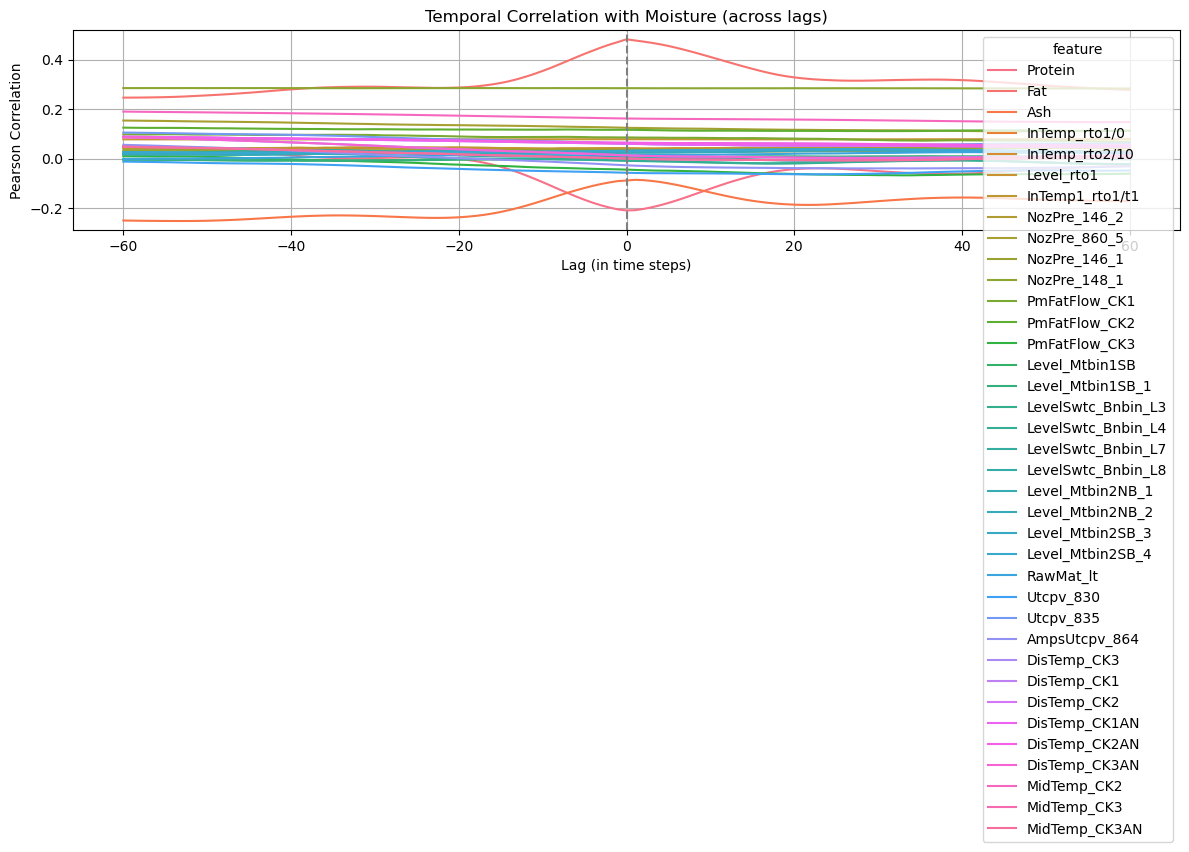

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

df_corr = df_corr.dropna(subset=['correlation'])

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_corr, x='lag', y='correlation', hue='feature')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Temporal Correlation with Moisture (across lags)')
plt.xlabel('Lag (in time steps)')
plt.ylabel('Pearson Correlation')
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
# Exporting time series pearson correlation analysis
df_corr.to_csv("ts_moisture_corr_raw.csv")

#### Protein

In [31]:
import numpy as np

max_lag = 60

results = []

for col in df.columns:
    if col in ['DATETIME', 'Protein']:
        continue

    for lag in range(-max_lag, max_lag + 1):
        # Shift the column
        shifted = df[col].shift(lag)

        # Combine into one DataFrame
        temp_df = pd.concat([df['Protein'], shifted], axis=1)
        temp_df.columns = ['Protein', 'Shifted']

        # Drop rows with NaNs
        temp_df = temp_df.dropna()

        # Skip if too few data points or any non-numeric types
        if len(temp_df) > 1 and np.issubdtype(temp_df['Protein'].dtype, np.number) and np.issubdtype(temp_df['Shifted'].dtype, np.number):
            corr = temp_df['Protein'].corr(temp_df['Shifted'])
        else:
            corr = np.nan

        results.append({
            'feature': col,
            'lag': lag,
            'correlation': corr
        })

df_corr = pd.DataFrame(results)

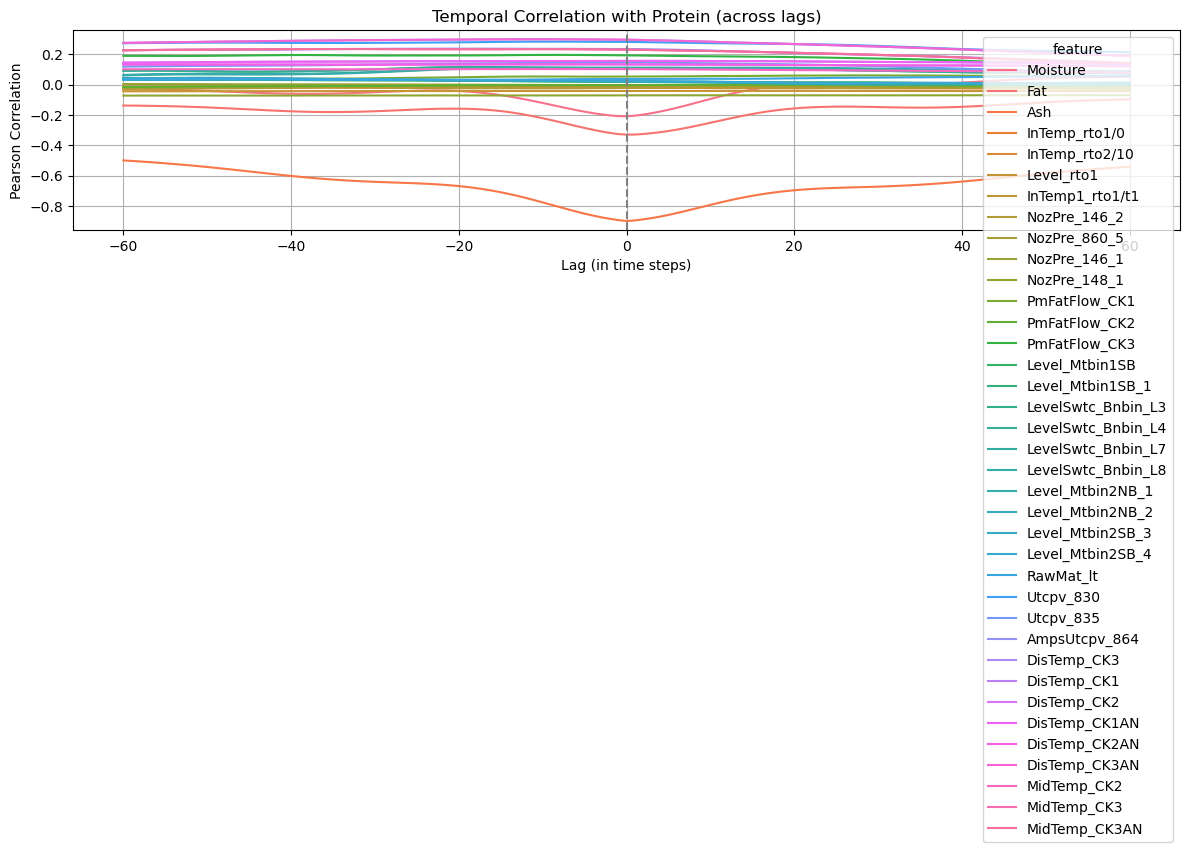

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

df_corr = df_corr.dropna(subset=['correlation'])

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_corr, x='lag', y='correlation', hue='feature')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Temporal Correlation with Protein (across lags)')
plt.xlabel('Lag (in time steps)')
plt.ylabel('Pearson Correlation')
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
# Exporting time series pearson correlation analysis
df_corr.to_csv("ts_protein_corr_raw.csv")

#### Ash

In [34]:
import numpy as np

max_lag = 60

results = []

for col in df.columns:
    if col in ['DATETIME', 'Ash']:
        continue

    for lag in range(-max_lag, max_lag + 1):
        # Shift the column
        shifted = df[col].shift(lag)

        # Combine into one DataFrame
        temp_df = pd.concat([df['Ash'], shifted], axis=1)
        temp_df.columns = ['Ash', 'Shifted']

        # Drop rows with NaNs
        temp_df = temp_df.dropna()

        # Skip if too few data points or any non-numeric types
        if len(temp_df) > 1 and np.issubdtype(temp_df['Ash'].dtype, np.number) and np.issubdtype(temp_df['Shifted'].dtype, np.number):
            corr = temp_df['Ash'].corr(temp_df['Shifted'])
        else:
            corr = np.nan

        results.append({
            'feature': col,
            'lag': lag,
            'correlation': corr
        })

df_corr = pd.DataFrame(results)

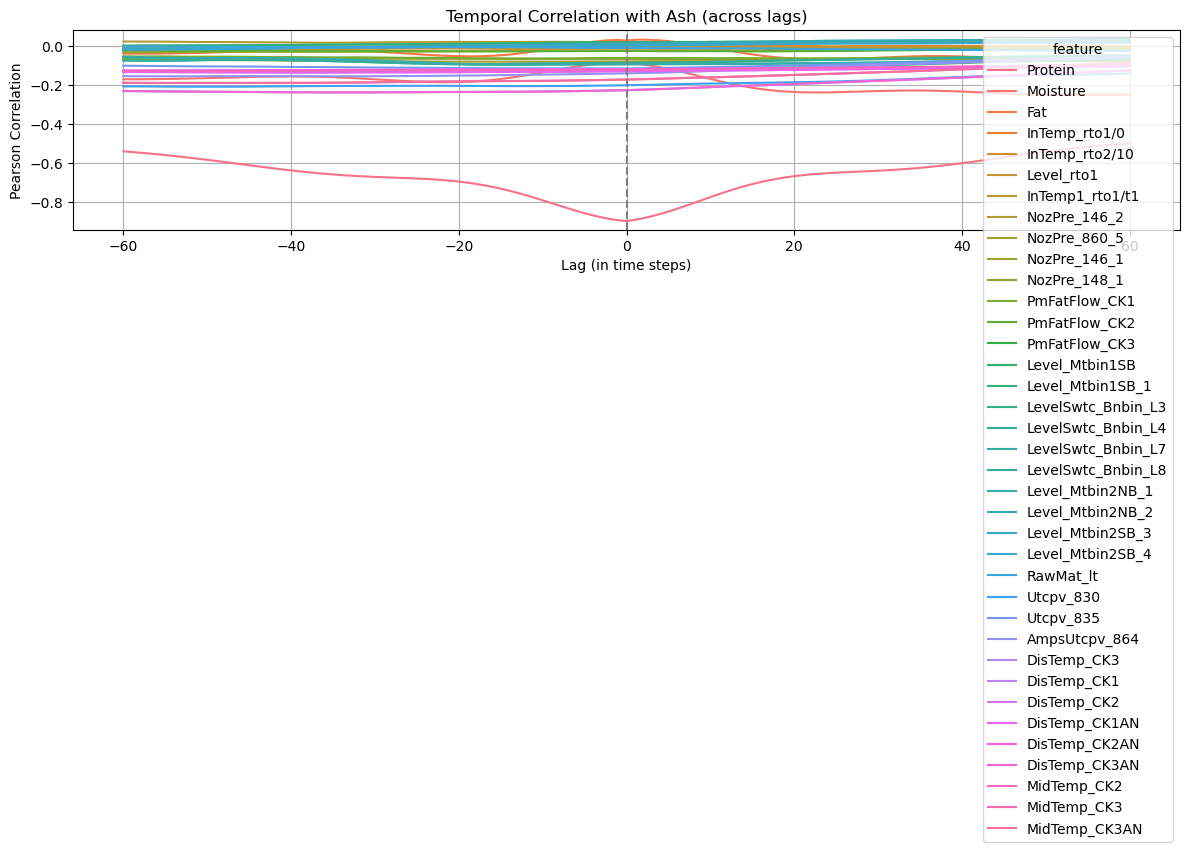

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

df_corr = df_corr.dropna(subset=['correlation'])

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_corr, x='lag', y='correlation', hue='feature')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Temporal Correlation with Ash (across lags)')
plt.xlabel('Lag (in time steps)')
plt.ylabel('Pearson Correlation')
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# Exporting time series pearson correlation analysis
df_corr.to_csv("ts_ash_corr_raw.csv")

#### Fat

In [37]:
import numpy as np

max_lag = 60

results = []

for col in df.columns:
    if col in ['DATETIME', 'Fat']:
        continue

    for lag in range(-max_lag, max_lag + 1):
        # Shift the column
        shifted = df[col].shift(lag)

        # Combine into one DataFrame
        temp_df = pd.concat([df['Fat'], shifted], axis=1)
        temp_df.columns = ['Fat', 'Shifted']

        # Drop rows with NaNs
        temp_df = temp_df.dropna()

        # Skip if too few data points or any non-numeric types
        if len(temp_df) > 1 and np.issubdtype(temp_df['Fat'].dtype, np.number) and np.issubdtype(temp_df['Shifted'].dtype, np.number):
            corr = temp_df['Fat'].corr(temp_df['Shifted'])
        else:
            corr = np.nan

        results.append({
            'feature': col,
            'lag': lag,
            'correlation': corr
        })

df_corr = pd.DataFrame(results)

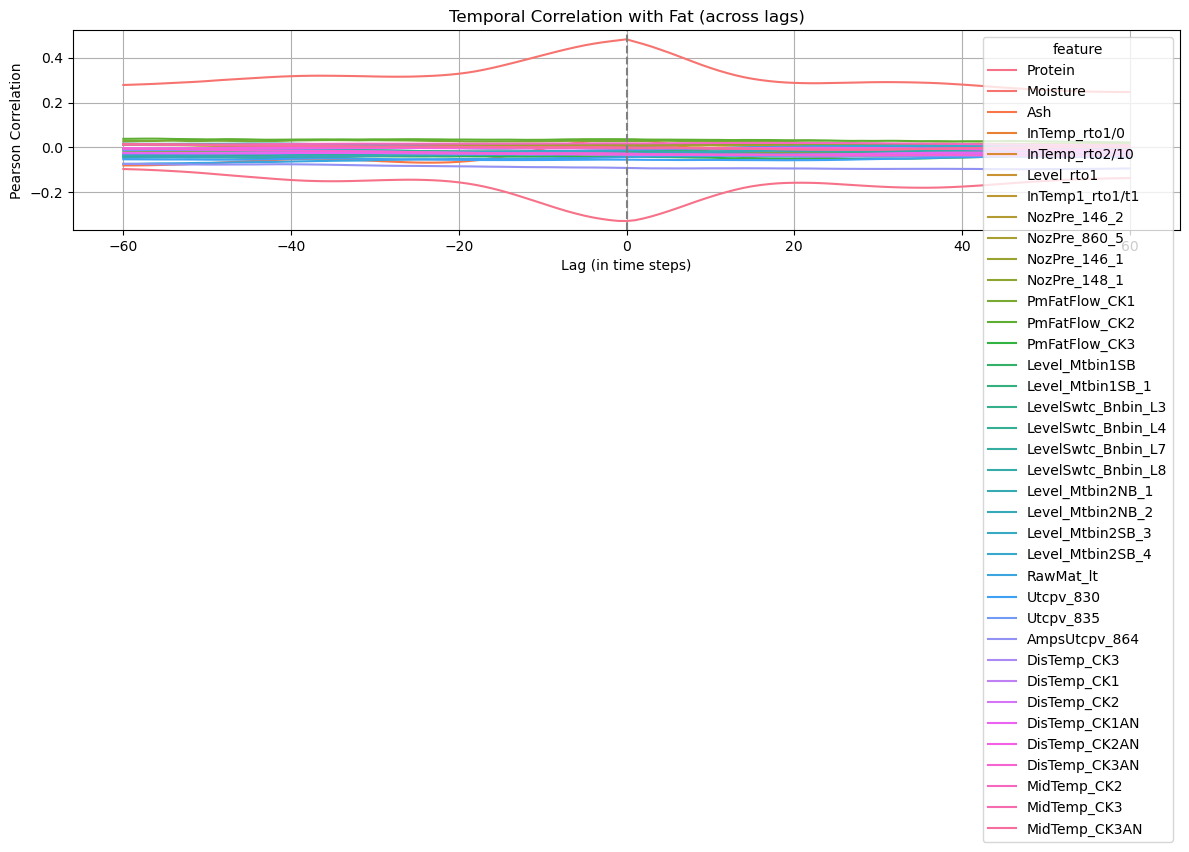

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

df_corr = df_corr.dropna(subset=['correlation'])

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_corr, x='lag', y='correlation', hue='feature')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Temporal Correlation with Fat (across lags)')
plt.xlabel('Lag (in time steps)')
plt.ylabel('Pearson Correlation')
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
# Exporting time series pearson correlation analysis
df_corr.to_csv("ts_fat_corr_raw.csv")

### Applying Max (Absolute Value) Correlation Temporal Shift

#### Moisture

In [12]:
max_lag = 60
results = []

for col in df.columns:
    if col in ['DATETIME', 'Moisture']:
        continue

    for lag in range(-max_lag, max_lag + 1):
        shifted = df[col].shift(lag)
        temp_df = pd.concat([df['Moisture'], shifted], axis=1)
        temp_df.columns = ['Moisture', 'Shifted']
        temp_df = temp_df.dropna()

        if len(temp_df) > 1 and np.issubdtype(temp_df['Moisture'].dtype, np.number) and np.issubdtype(temp_df['Shifted'].dtype, np.number):
            corr = temp_df['Moisture'].corr(temp_df['Shifted'])
        else:
            corr = np.nan

        results.append({
            'feature': col,
            'lag': lag,
            'correlation': corr
        })

df_corr = pd.DataFrame(results)

# Keep only the lag with the greatest absolute correlation per feature
df_moisture_corr = df_corr.loc[df_corr.groupby('feature')['correlation'].apply(lambda x: x.abs().idxmax())].reset_index(drop=True)

In [13]:
# Exporting time series pearson correlation max values (absolute) for moisture
df_moisture_corr.to_csv('moisture_ts_correlation.CSV')

In [14]:
# Copying df
df_moisture_shifted = df.copy()

# Loop over each row in the summary table
for _, row in df_moisture_corr.iterrows():
    feature = row['feature']
    lag = int(row['lag'])  # ensure it's an integer
    df_moisture_shifted[feature] = df[feature].shift(lag)

# Dropping first and last sixty entries to remove introduced NaNs from temporal shift
df_moisture_shifted = df_moisture_shifted.iloc[60:-60].reset_index(drop=True)

In [15]:
# Exporting temporally shifted data for moisture
df_moisture_shifted.to_csv('df_moisture_shifted.csv')

#### Protein

In [16]:
max_lag = 60
results = []

for col in df.columns:
    if col in ['DATETIME', 'Protein']:
        continue

    for lag in range(-max_lag, max_lag + 1):
        shifted = df[col].shift(lag)
        temp_df = pd.concat([df['Protein'], shifted], axis=1)
        temp_df.columns = ['Protein', 'Shifted']
        temp_df = temp_df.dropna()

        if len(temp_df) > 1 and np.issubdtype(temp_df['Protein'].dtype, np.number) and np.issubdtype(temp_df['Shifted'].dtype, np.number):
            corr = temp_df['Protein'].corr(temp_df['Shifted'])
        else:
            corr = np.nan

        results.append({
            'feature': col,
            'lag': lag,
            'correlation': corr
        })

df_corr = pd.DataFrame(results)

# Keep only the lag with the greatest absolute correlation per feature
df_protein_corr = df_corr.loc[df_corr.groupby('feature')['correlation'].apply(lambda x: x.abs().idxmax())].reset_index(drop=True)

In [17]:
# Exporting time series pearson correlation max values (absolute) for protein
df_protein_corr.to_csv('protein_ts_correlation.CSV')

In [18]:
# Copying df
df_protein_shifted = df.copy()

# Loop over each row in the summary table
for _, row in df_protein_corr.iterrows():
    feature = row['feature']
    lag = int(row['lag'])  # ensure it's an integer
    df_protein_shifted[feature] = df[feature].shift(lag)

# Dropping first and last sixty entries to remove introduced NaNs from temporal shift
df_protein_shifted = df_protein_shifted.iloc[60:-60].reset_index(drop=True)

In [19]:
# Exporting temporally shifted data for protein
df_protein_shifted.to_csv('df_protein_shifted.csv')

#### Ash

In [20]:
max_lag = 60
results = []

for col in df.columns:
    if col in ['DATETIME', 'Ash']:
        continue

    for lag in range(-max_lag, max_lag + 1):
        shifted = df[col].shift(lag)
        temp_df = pd.concat([df['Ash'], shifted], axis=1)
        temp_df.columns = ['Ash', 'Shifted']
        temp_df = temp_df.dropna()

        if len(temp_df) > 1 and np.issubdtype(temp_df['Ash'].dtype, np.number) and np.issubdtype(temp_df['Shifted'].dtype, np.number):
            corr = temp_df['Ash'].corr(temp_df['Shifted'])
        else:
            corr = np.nan

        results.append({
            'feature': col,
            'lag': lag,
            'correlation': corr
        })

df_corr = pd.DataFrame(results)

# Keep only the lag with the greatest absolute correlation per feature
df_ash_corr = df_corr.loc[df_corr.groupby('feature')['correlation'].apply(lambda x: x.abs().idxmax())].reset_index(drop=True)

In [21]:
# Exporting time series pearson correlation max values (absolute) for ash
df_ash_corr.to_csv('ash_ts_correlation.CSV')

In [22]:
# Copying df
df_ash_shifted = df.copy()

# Loop over each row in the summary table
for _, row in df_ash_corr.iterrows():
    feature = row['feature']
    lag = int(row['lag'])  # ensure it's an integer
    df_ash_shifted[feature] = df[feature].shift(lag)

# Dropping first and last sixty entries to remove introduced NaNs from temporal shift
df_ash_shifted = df_ash_shifted.iloc[60:-60].reset_index(drop=True)

In [23]:
# Exporting temporally shifted data for ash
df_ash_shifted.to_csv('df_ash_shifted.csv')

#### Fat

In [24]:
max_lag = 60
results = []

for col in df.columns:
    if col in ['DATETIME', 'Fat']:
        continue

    for lag in range(-max_lag, max_lag + 1):
        shifted = df[col].shift(lag)
        temp_df = pd.concat([df['Fat'], shifted], axis=1)
        temp_df.columns = ['Fat', 'Shifted']
        temp_df = temp_df.dropna()

        if len(temp_df) > 1 and np.issubdtype(temp_df['Fat'].dtype, np.number) and np.issubdtype(temp_df['Shifted'].dtype, np.number):
            corr = temp_df['Fat'].corr(temp_df['Shifted'])
        else:
            corr = np.nan

        results.append({
            'feature': col,
            'lag': lag,
            'correlation': corr
        })

df_corr = pd.DataFrame(results)

# Keep only the lag with the greatest absolute correlation per feature
df_fat_corr = df_corr.loc[df_corr.groupby('feature')['correlation'].apply(lambda x: x.abs().idxmax())].reset_index(drop=True)

In [25]:
# Exporting time series pearson correlation max values (absolute) for fat
df_fat_corr.to_csv('fat_ts_correlation.CSV')

In [26]:
# Copying df
df_fat_shifted = df.copy()

# Loop over each row in the summary table
for _, row in df_fat_corr.iterrows():
    feature = row['feature']
    lag = int(row['lag'])  # ensure it's an integer
    df_fat_shifted[feature] = df[feature].shift(lag)

# Dropping first and last sixty entries to remove introduced NaNs from temporal shift
df_fat_shifted = df_fat_shifted.iloc[60:-60].reset_index(drop=True)

In [27]:
# Exporting temporally shifted data for fat
df_fat_shifted.to_csv('df_fat_shifted.csv')